## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1. Camera Calibration

In [18]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

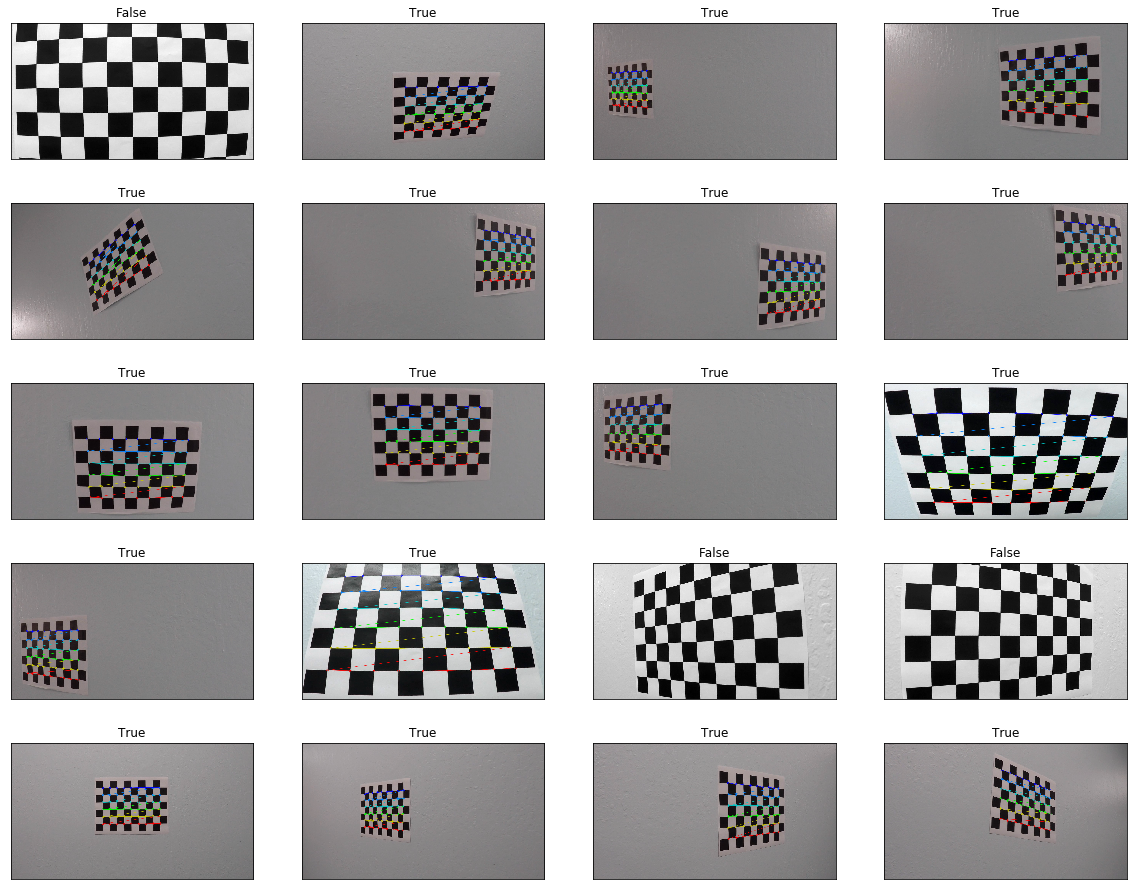

In [23]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize = (20, 16))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # print(fname, img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
        r = i % 4
        c = i // 4
        ax[c][r].imshow(img)
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
    else:
        r = i % 4
        c = i // 4
        ax[c][r].imshow(gray, cmap = 'gray')
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
plt.savefig('./output_images/chessboard_corners.jpg')
#cv2.destroyAllWindows()
# Save the chessboard corners result for later use 
chessboard_pickle = {}
chessboard_pickle["objpoints"] = objpoints
chessboard_pickle["imgpoints"] = imgpoints
pickle.dump(chessboard_pickle, open( "chessboard_corners.p", "wb" ) )

In [24]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#Distortion correct the test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/calibration3_undist.jpg',dst)

True

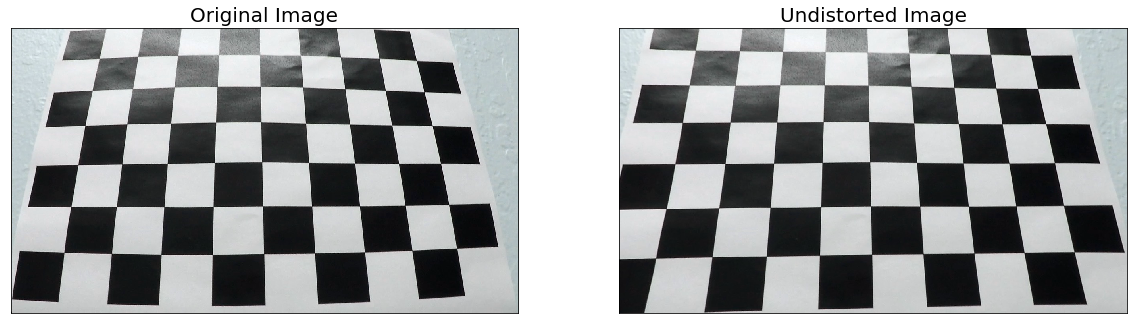

In [28]:
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_calibration.p", "wb"))

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img);
ax1.set_xticks(())
ax1.set_yticks(())
ax1.set_title('Original Image', fontsize=20);
ax2.imshow(dst);
ax2.set_xticks(())
ax2.set_yticks(())
ax2.set_title('Undistorted Image', fontsize=20);
plt.savefig('./output_images/camera_calibration.jpg')